<div class="alert alert-block alert-success">
    <b><center>CNN Basic Examples</center></b>
    <b><center>Basic CNN</center></b>
</div>

# Configure Learning Environment

In [1]:
# !pip install git+https://github.com/nockchun/rspy --force
# !pip install mybatis_mapper2sql
import rspy as rsp
rsp.setSystemWarning(off=True)

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, datasets, utils

In [3]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
np.set_printoptions(linewidth=200, precision=2)
tf.__version__

'2.4.1'

# Use the same graph of layers to define multiple models
In the functional API, models are created by specifying their inputs and outputs in a graph of layers. That means that a single graph of layers can be used to generate multiple models.

In the example below, you use the same stack of layers to instantiate two models: an encoder model that turns image inputs into 16-dimensional vectors, and an end-to-end autoencoder model for training.

In [5]:
encoder_input = layers.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

In [6]:
encoder = models.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [7]:
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

In [8]:
autoencoder = models.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                

Here, the decoding architecture is strictly symmetrical to the encoding architecture, so the output shape is the same as the input shape (28, 28, 1).

The reverse of a Conv2D layer is a Conv2DTranspose layer, and the reverse of a MaxPooling2D layer is an UpSampling2D layer.

# All models are callable, just like layers
You can treat any model as if it were a layer by invoking it on an Input or on the output of another layer. By calling a model you aren't just reusing the architecture of the model, you're also reusing its weights.

To see this in action, here's a different take on the autoencoder example that creates an encoder model, a decoder model, and chains them in two calls to obtain the autoencoder model:

In [9]:
encoder_input = layers.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

In [10]:
encoder = models.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

In [11]:
decoder_input = layers.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

In [12]:
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 6, 6, 16)          160       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 26, 26, 16)        4624      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         145 

In [13]:
autoencoder_input = layers.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = models.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                18672     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


As you can see, the model can be nested: a model can contain sub-models (since a model is just like a layer). A common use case for model nesting is ensembling. For example, here's how to ensemble a set of models into a single model that averages their predictions:

In [14]:
def get_model():
    inputs = layers.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return models.Model(inputs, outputs)

In [15]:
model1 = get_model()
model2 = get_model()
model3 = get_model()

In [16]:
inputs = layers.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = models.Model(inputs=inputs, outputs=outputs)

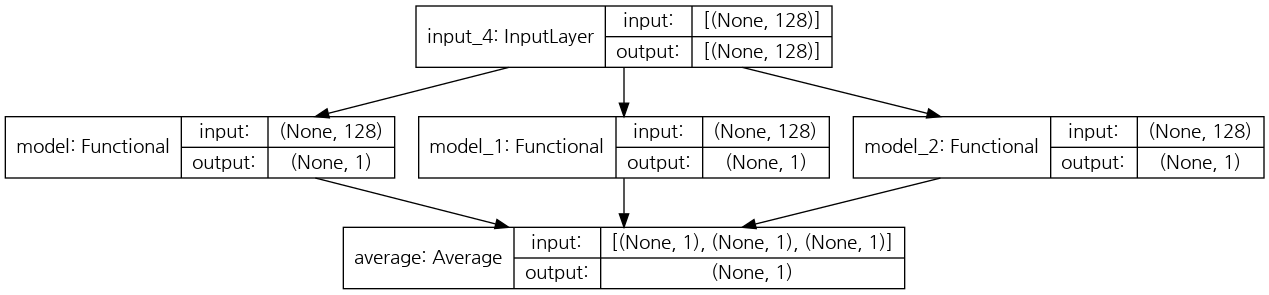

In [17]:
utils.plot_model(ensemble_model, "intermediate/model.png", True)

# Manipulate complex graph topologies

Models with multiple inputs and outputs
The functional API makes it easy to manipulate multiple inputs and outputs. This cannot be handled with the Sequential API.

For example, if you're building a system for ranking customer issue tickets by priority and routing them to the correct department, then the model will have three inputs:

* the title of the ticket (text input),
* the text body of the ticket (text input), and
* any tags added by the user (categorical input)

This model will have two outputs:
* the priority score between 0 and 1 (scalar sigmoid output), and
* the department that should handle the ticket (softmax output over the set of departments).

You can build this model in a few lines with the functional API:

In [18]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

In [19]:
title_input = layers.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = layers.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = layers.Input(shape=(num_tags,), name="tags")  # Binary vectors of size `num_tags`

In [20]:
# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

In [21]:
# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

In [22]:
# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

In [23]:
# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

In [24]:
# Instantiate an end-to-end model predicting both priority and department
model = models.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

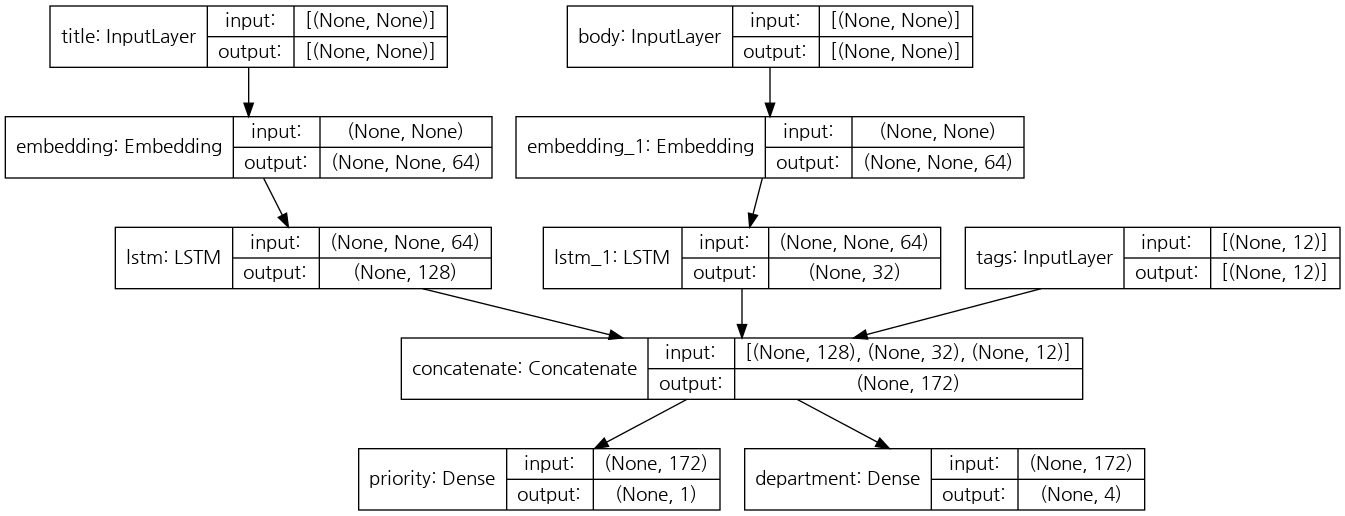

In [25]:
utils.plot_model(model, "intermediate/model.png", show_shapes=True)

When compiling this model, you can assign different losses to each output. You can even assign different weights to each loss -- to modulate their contribution to the total training loss.

In [26]:
model.compile(
    optimizer=optimizers.RMSprop(1e-3),
    loss=[
        losses.BinaryCrossentropy(from_logits=True),
        losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

Since the output layers have different names, you could also specify the loss like this:

In [27]:
model.compile(
    optimizer=optimizers.RMSprop(1e-3),
    loss={
        "priority": losses.BinaryCrossentropy(from_logits=True),
        "department": losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

Train the model by passing lists of NumPy arrays of inputs and targets:

In [28]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

In [29]:
# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node gradient_tape/model_4/embedding/embedding_lookup/Reshape/_36}}]] [Op:__inference_train_function_6155]

Function call stack:
train_function


When calling fit with a Dataset object, it should yield either a tuple of lists like ([title_data, body_data, tags_data], [priority_targets, dept_targets]) or a tuple of dictionaries like ({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets}).

# Shared layers
Another good use for the functional API are models that use shared layers. Shared layers are layer instances that are reused multiple times in the same model -- they learn features that correspond to multiple paths in the graph-of-layers.

Shared layers are often used to encode inputs from similar spaces (say, two different pieces of text that feature similar vocabulary). They enable sharing of information across these different inputs, and they make it possible to train such a model on less data. If a given word is seen in one of the inputs, that will benefit the processing of all inputs that pass through the shared layer.

To share a layer in the functional API, call the same layer instance multiple times. For instance, here's an Embedding layer shared across two different text inputs:

In [ ]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

In [ ]:
# Variable-length sequence of integers
text_input_a = layers.Input(shape=(None,), dtype="int32")

In [ ]:
# Variable-length sequence of integers
text_input_b = layers.Input(shape=(None,), dtype="int32")

In [ ]:
# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

# Extract and reuse nodes in the graph of layers
Because the graph of layers you are manipulating is a static data structure, it can be accessed and inspected. And this is how you are able to plot functional models as images.

This also means that you can access the activations of intermediate layers ("nodes" in the graph) and reuse them elsewhere -- which is very useful for something like feature extraction.

Let's look at an example. This is a VGG19 model with weights pretrained on ImageNet:

In [ ]:
vgg19 = tf.keras.applications.VGG19()

And these are the intermediate activations of the model, obtained by querying the graph data structure:

In [ ]:
features_list = [layer.output for layer in vgg19.layers]

Use these features to create a new feature-extraction model that returns the values of the intermediate layer activations:

In [ ]:
feat_extraction_model = models.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

This comes in handy for tasks like [neural style transfer](https://keras.io/examples/generative/neural_style_transfer/), among other things.

# Extend the API using custom layers

tf.keras includes a wide range of built-in layers, for example:
* Convolutional layers: Conv1D, Conv2D, Conv3D, Conv2DTranspose
* Pooling layers: MaxPooling1D, MaxPooling2D, MaxPooling3D, AveragePooling1D
* RNN layers: GRU, LSTM, ConvLSTM2D
* BatchNormalization, Dropout, Embedding, etc.

But if you don't find what you need, it's easy to extend the API by creating your own layers. All layers subclass the Layer class and implement:

* call method, that specifies the computation done by the layer.
* build method, that creates the weights of the layer (this is just a style convention since you can create weights in __init__, as well).

To learn more about creating layers from scratch, read custom layers and models guide.

The following is a basic implementation of tf.keras.layers.Dense:

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [ ]:
inputs = layers.Input((4,))
outputs = CustomDense(10)(inputs)

model = models.Model(inputs, outputs)

For serialization support in your custom layer, define a get_config method that returns the constructor arguments of the layer instance:

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}

In [ ]:
inputs = layers.Input((4,))
outputs = CustomDense(10)(inputs)

In [ ]:
model = models.Model(inputs, outputs)
config = model.get_config()

In [ ]:
new_model = models.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

Optionally, implement the class method from_config(cls, config) which is used when recreating a layer instance given its config dictionary. The default implementation of from_config is:

In [ ]:
def from_config(cls, config):
  return cls(**config)

# When to use the functional API
Should you use the Keras functional API to create a new model, or just subclass the Model class directly? In general, the functional API is higher-level, easier and safer, and has a number of features that subclassed models do not support.

However, model subclassing provides greater flexibility when building models that are not easily expressible as directed acyclic graphs of layers. For example, you could not implement a Tree-RNN with the functional API and would have to subclass Model directly.

For an in-depth look at the differences between the functional API and model subclassing, read [What are Symbolic and Imperative APIs in TensorFlow 2.0?](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html).

Functional API strengths:

The following properties are also true for Sequential models (which are also data structures), but are not true for subclassed models (which are Python bytecode, not data structures).

Less verbose
There is no super(MyClass, self).__init__(...), no def call(self, ...):, etc.

Compare:

In [ ]:
inputs = layers.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = models.Model(inputs, outputs)

With the subclassed version:

In [ ]:
class MLP(models.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))

**Model validation while defining its connectivity graph**

In the functional API, the input specification (shape and dtype) is created in advance (using Input). Every time you call a layer, the layer checks that the specification passed to it matches its assumptions, and it will raise a helpful error message if not.

This guarantees that any model you can build with the functional API will run. All debugging -- other than convergence-related debugging -- happens statically during the model construction and not at execution time. This is similar to type checking in a compiler.

**A functional model is plottable and inspectable**

You can plot the model as a graph, and you can easily access intermediate nodes in this graph. For example, to extract and reuse the activations of intermediate layers (as seen in a previous example):

In [ ]:
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = models.Model(inputs=vgg19.input, outputs=features_list)

**A functional model can be serialized or cloned**

Because a functional model is a data structure rather than a piece of code, it is safely serializable and can be saved as a single file that allows you to recreate the exact same model without having access to any of the original code. See the serialization & saving guide.

To serialize a subclassed model, it is necessary for the implementer to specify a get_config() and from_config() method at the model level.

**Functional API weakness:**

It does not support dynamic architectures
The functional API treats models as DAGs of layers. This is true for most deep learning architectures, but not all -- for example, recursive networks or Tree RNNs do not follow this assumption and cannot be implemented in the functional API.

# Mix-and-match API styles
Choosing between the functional API or Model subclassing isn't a binary decision that restricts you into one category of models. All models in the tf.keras API can interact with each other, whether they're Sequential models, functional models, or subclassed models that are written from scratch.

You can always use a functional model or Sequential model as part of a subclassed model or layer:

In [ ]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = layers.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = models.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

You can use any subclassed layer or model in the functional API as long as it implements a call method that follows one of the following patterns:

* call(self, inputs, **kwargs) -- Where inputs is a tensor or a nested structure of tensors (e.g. a list of tensors), and where **kwargs are non-tensor arguments (non-inputs).
*call(self, inputs, training=None, **kwargs) -- Where training is a boolean indicating whether the layer should behave in training mode and inference mode.
*call(self, inputs, mask=None, **kwargs) -- Where mask is a boolean mask tensor (useful for RNNs, for instance).
*call(self, inputs, training=None, mask=None, **kwargs) -- Of course, you can have both masking and training-specific behavior at the same time.

Additionally, if you implement the get_config method on your custom Layer or model, the functional models you create will still be serializable and cloneable.

Here's a quick example of a custom RNN, written from scratch, being used in a functional model:

In [ ]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = layers.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = models.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))